<center> <img src = https://upload.wikimedia.org/wikipedia/commons/e/e3/Booking.com_logo2.png alt="drawing" style="width:400px;">

## Постановка задачи

Представьте, что вы работаете датасаентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.

Первоначальная версия датасета содержит 17 полей со следующей информацией:

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

---

## Загрузка данных

In [193]:
# импортируем необходимые модули
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.downloader.download('vader_lexicon')
from afinn import Afinn

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [194]:
RANDOM_SEED = 42

In [195]:
# Подгрузим наши данные из соревнования
DATA_DIR = 'C:/Users/admin/DSPR-2.0/Projects/project_3'
hotels = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [196]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [197]:
hotels.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,384355.000000,384355.000000
mean,498.246536,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,49.443522,2.823402
std,500.258012,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,3.466936,4.579043
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,48.214662,-0.143649
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,51.499981,-0.000250
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,52.400181,16.429233


---

## Очистка данных

In [ ]:
# удаляем полные дупликаты
hotels = hotels.drop_duplicates(ignore_index=True)
print(f'Результирующее число записей: {hotels.shape[0]}')

: 

: 

: 

Пока что заполним пропущенные широту и долготу нулями, затем если обнаружим заисимость оценки от этих признаков, заполним их по адресу

In [ ]:
# заменяем пропуски на нули
values = {'lat': 0, 'lng': 0}
hotels = hotels.fillna(values)

При осмотре общих статистик, у некоторых признаков можно заметить большую разницу между максимальным значением и 75 процентилем, что является признаком наличия выбросов. Посмотрим на распределения этих признаков.

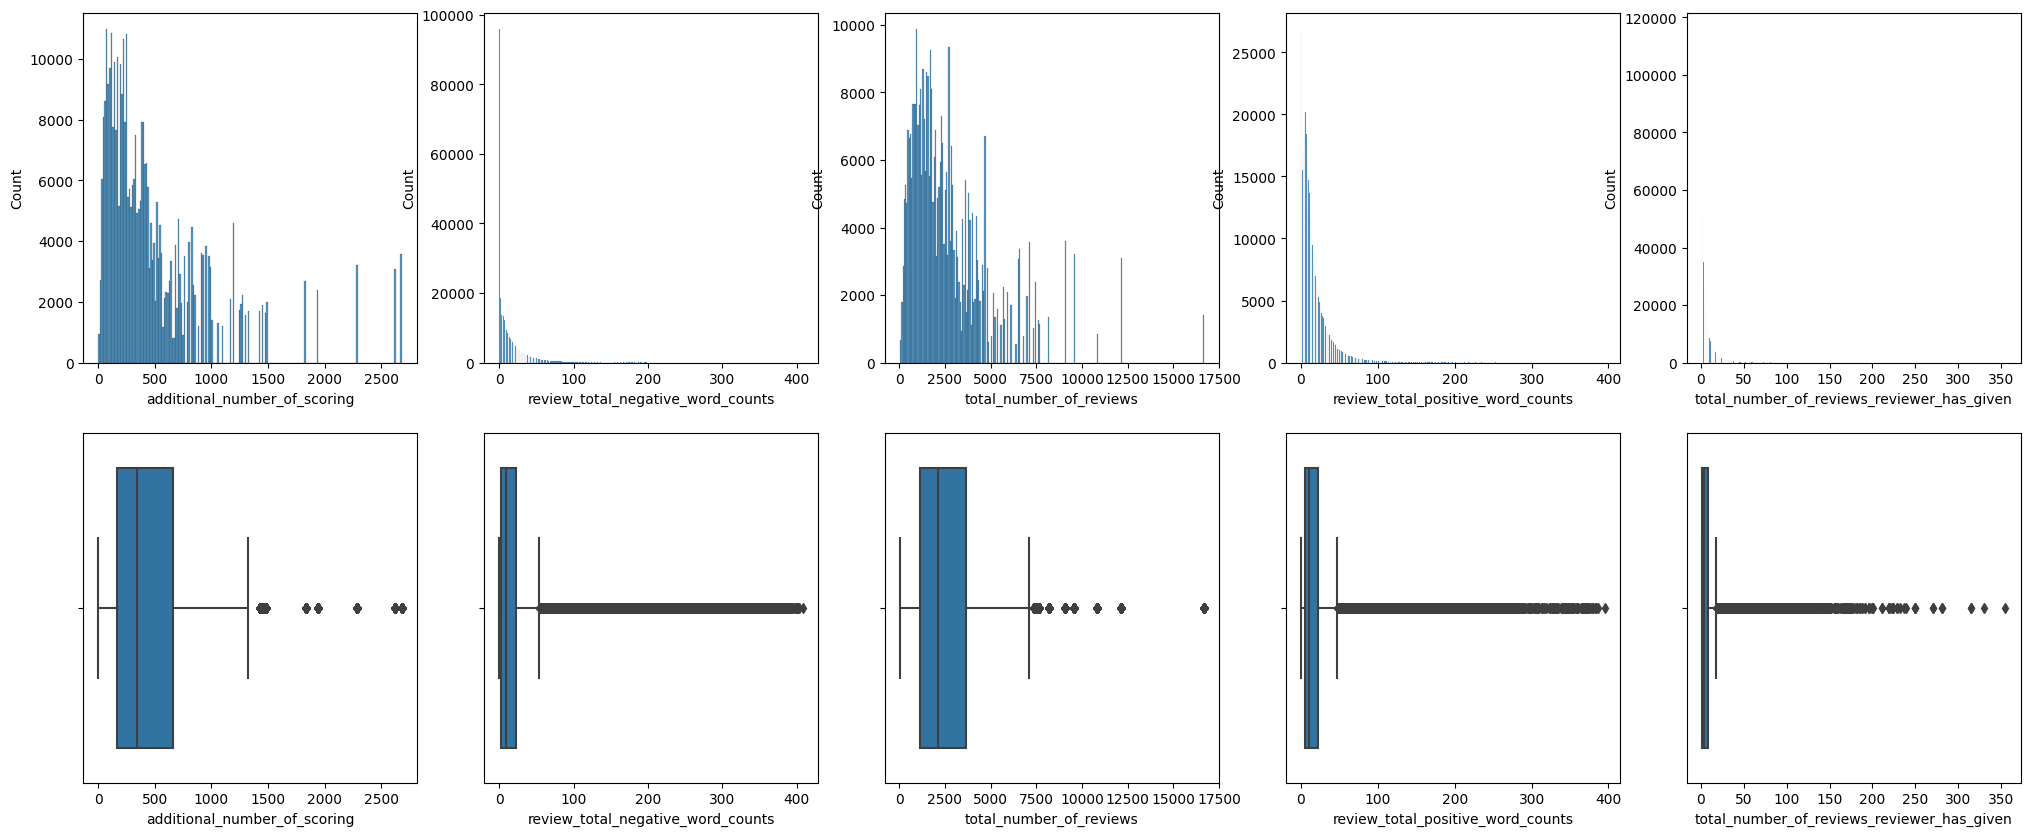

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize = (25, 10))

outliers_fig = ['additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given']
n = 0
for i in outliers_fig:
    histplot = sns.histplot(data=hotels, x=i, ax=axes[0][n]);
    boxplot = sns.boxplot(data=hotels, x=i, ax=axes[1][n]);
    n += 1

Из распределений видно что имеются выбросы, но данные значения признаков вполне имеют право на существование, т.к. например для особенно популярного отеля вполне может быть выставленно большое количество оценок или отзывов. 

На данном этапе удалять выбросы не будем.

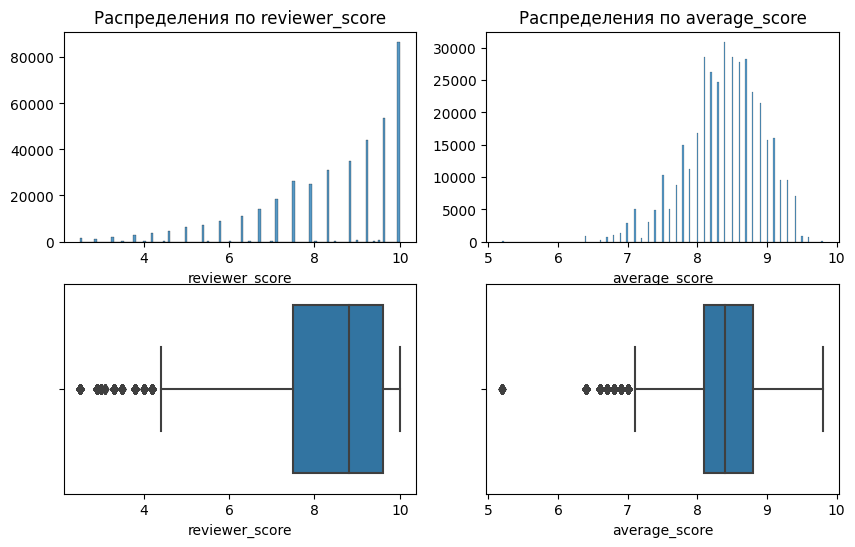

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
histplot = sns.histplot(data=hotels, x='reviewer_score', ax=axes[0][0])
histplot.set_title('Распределения по reviewer_score')
histplot.set_ylabel('')
boxplot = sns.boxplot(data=hotels, x='reviewer_score', ax=axes[1][0])
histplot = sns.histplot(data=hotels, x='average_score', ax=axes[0][1])
histplot.set_title('Распределения по average_score')
histplot.set_ylabel('')
boxplot = sns.boxplot(data=hotels, x='average_score', ax=axes[1][1])

In [ ]:
hotels = hotels.reset_index(drop=True)

---

## Разведывательный анализ данных

***Каждое изменение датасета будем оборачивать в функции, тем самым, после обучения модели, каждые вновь поступающие данные мы будем изменять с помощью этих функций и подавать на вход модели для предсказания целевого значения. Таким образом мы избавимся от необходимости постоянного обучения модели.***

### Проектирование признаков

In [ ]:
train_data = hotels.copy()
train_data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


Набросаем примерный план обработки признаков:
* Из признака hotel_address возьмём страну и город
* Из признака review_date: год, месяц и квартал
* hotel_name скорее всего ничем не поможет
* reviewer_nationality, есть две идеи:
    1. из внешних источников взять какой-нибудь индекс качества жизни (возможно рецензенты из стран с низким качеством жизни ставят отелям более высокие оценки)
    2. возможно рецензенты, национальность которых совпадает с страной отеля, ставят оценки выше либо ниже
* negative_review и positive_review, можно попробовать разделить на степени недовольства или удовлетворённости, по вхождению в отзыв таких слов как: восхитительный, великолепный или отвратительный, мерзкий. Затем применим библиотеки анализа текстов.
* Из признака tags можно будет выделить: тип поездки, количество комнат в номере, количество человек и т.д.

#### <CENTER>Признак hotel_address</CENTER>

In [ ]:
n = 0
for i in train_data['hotel_address']:
    print(i)
    n += 1
    if n > 5:
        break

Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom
130 134 Southampton Row Camden London WC1B 5AF United Kingdom
151 bis Rue de Rennes 6th arr 75006 Paris France
216 Avenue Jean Jaures 19th arr 75019 Paris France
Molenwerf 1 1014 AG Amsterdam Netherlands
Via Mecenate 121 20138 Milan Italy


Из данного признака выделим страну и город расположения отеля

In [ ]:
def hotel_address_func(data):
    """Функция преобразования признака hotel_address

    Args:
        data (DataFrame): Изначальный датасет

    Returns:
        DataFrame: преобразованный датасет
    """
    data['country'] = data['hotel_address'].apply(lambda x: x.split()[-1] if (x.split()[-1] != 'Kingdom') else (x.split()[-2] + ' ' + x.split()[-1])) # создаём признак страна отеля
    data['city'] = data['hotel_address'].apply(lambda x: x.split()[-2] if (x.split()[-1] != 'Kingdom') else x.split()[-5])                            # создаём признак город отеля
    
    return data


In [ ]:
train_data = hotel_address_func(train_data)

In [ ]:
print('Страна расположения отелей\n', train_data['country'].value_counts(), '\n')
print('Город расположения отелей\n', train_data['city'].value_counts())

Страна расположения отелей
 United Kingdom    196773
Spain              45132
France             44528
Netherlands        43004
Austria            29177
Italy              27882
Name: country, dtype: int64 

Город расположения отелей
 London       196773
Barcelona     45132
Paris         44528
Amsterdam     43004
Vienna        29177
Milan         27882
Name: city, dtype: int64


Сразу подметим что два новых признака полностью совпадают (для каждой страны по одному городу), значит в дальнейшем один из них, удалим. Так как все страны из Европы, то географичиские координаты вероятнее всего нам не понадобятся.

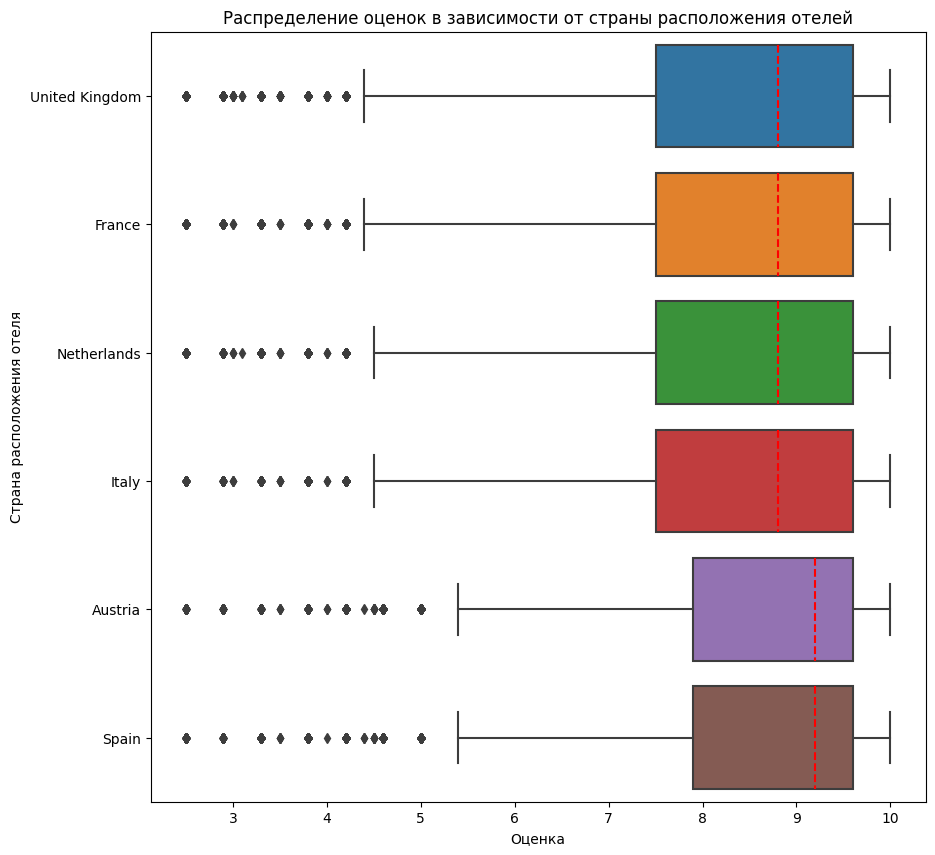

In [ ]:
ax = sns.boxplot(train_data, x='reviewer_score', y='country', orient='h', medianprops={'color':'red', 'linestyle':'--'})
ax.set(xlabel='Оценка', ylabel='Страна расположения отеля')
plt.title('Распределение оценок в зависимости от страны расположения отелей')
plt.show()

Судя по распределениям, статистически значимая зависимость оценок от страны, отсутствует.

#### <CENTER>Признак review_date</CENTER>

Из даты нам пригодятся: год, месяц и квартал

In [ ]:
def review_date_func(data):
    """Функция преобразования признака review_date

    Args:
        data (DataFrame): Изначальный датасет

    Returns:
        DataFrame: преобразованный датасет
    """
    data['review_date'] = pd.to_datetime(data['review_date'])
    
    data['review_year'] = data['review_date'].dt.year           # год
    data['review_month'] = data['review_date'].dt.month         # месяц
    data['review_quarter'] = data['review_date'].dt.quarter     # квартал
    
    return data

In [ ]:
train_data = review_date_func(train_data)

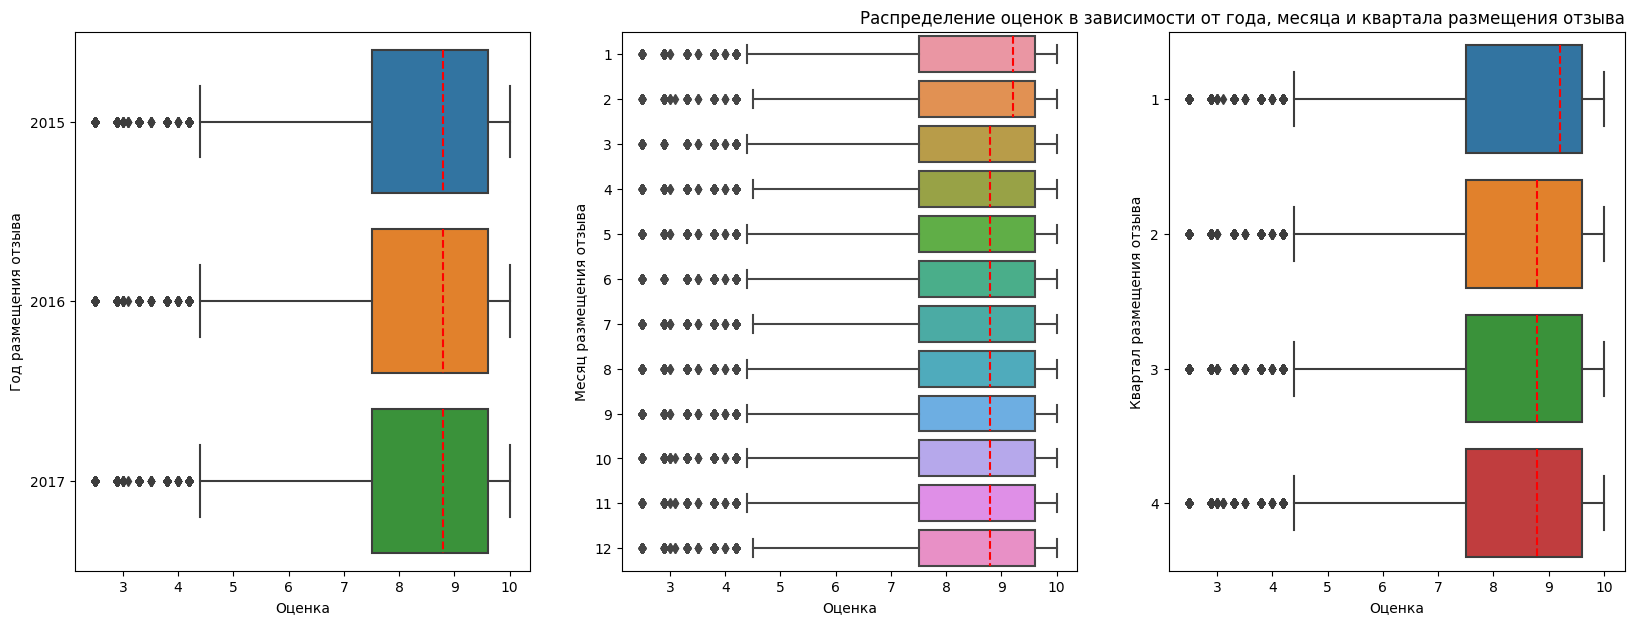

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
sns.boxplot(train_data, x='reviewer_score', y='review_year', orient='h', medianprops={'color':'red', 'linestyle':'--'}, ax=axes[0])
axes[0].set(xlabel='Оценка', ylabel='Год размещения отзыва')
sns.boxplot(train_data, x='reviewer_score', y='review_month', orient='h', medianprops={'color':'red', 'linestyle':'--'}, ax=axes[1])
axes[1].set(xlabel='Оценка', ylabel='Месяц размещения отзыва')
sns.boxplot(train_data, x='reviewer_score', y='review_quarter', orient='h', medianprops={'color':'red', 'linestyle':'--'}, ax=axes[2])
axes[2].set(xlabel='Оценка', ylabel='Квартал размещения отзыва')

plt.title('Распределение оценок в зависимости от года, месяца и квартала размещения отзыва', loc='right')
plt.show()

Оценка независит от даты размещения отзыва

#### <CENTER>Признак hotel_name</CENTER>

In [ ]:
train_data['hotel_name'].head(10)

0                           The May Fair Hotel
1              Mercure London Bloomsbury Hotel
2            Legend Saint Germain by Elegancia
3    Mercure Paris 19 Philharmonie La Villette
4                  Golden Tulip Amsterdam West
5              Novotel Milano Linate Aeroporto
6          Holiday Inn London Kensington Forum
7                       Mercure Josefshof Wien
8         The Gore Hotel Starhotels Collezione
9               Hilton London Kensington Hotel
Name: hotel_name, dtype: object

Данный признак не информативен

#### <CENTER>Признак reviewer_nationality</CENTER>

1. Создадим признак совпадения национальности и страны отеля
2. Возьмём из внешних источников уровень качества жизни и среднюю зарплату

In [ ]:
def reviewer_nationality_func(data):
    """Функция преобразования признака reviewer_nationality
       Создаём признак совпадения национальности и страны отеля и
       добавляем из внешних источников уровень качества жизни и среднюю зарплату.
    Args:
        data (DataFrame): Изначальный датасет

    Returns:
        DataFrame: преобразованный датасет
    """   
    data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())                                                      # удаляем лишние пробелы в названиях
    
    # 1. Создаём признак совпадения национальности и страны отеля
    data['country_equal_nation'] = 0
    for i in range(data.shape[0]):
        data.at[i, 'country_equal_nation'] = 1 if (data.at[i, 'reviewer_nationality'] == data.at[i, 'country']) else 0


    # 2. Создаём признак уровень качества жизни в стране рецензента
    # код для получения словаря стран и индекса уровня качества жизни
    url = 'https://www.numbeo.com/quality-of-life/rankings_by_country.jsp?title=2017&displayColumn=0'
    response = requests.get(url)                                                                                                                # делаем get запрос
    page = BeautifulSoup(response.text, 'html.parser')                                                                                          # готовим суп (получаем объект типа BeautifulSoup)

    countries = page.find_all('td', class_="cityOrCountryInIndicesTable")                                                                       # поиск стран по тегам
    indexes = page.find('tbody').find_all('td', style="text-align: right")                                                                      # поиск индексов по тегам

    country_dict = {'nation_country':[country.text for country in countries], 'quality_of_life':[float(indexx.text) for indexx in indexes]}     # собираем словарь
    country_dict['nation_country'].extend(['Kuwait', 'Malta', 'Bahrain', 'Oman', 'Luxembourg', 'Iceland', 'Jersey'])                            # дополняем словарь недостающими значениями стран
    country_dict['quality_of_life'].extend([146.0, 142.0, 146.0, 146.0, 185.0, 165.0, 170.0])                                                   # и их индексами
    # добавляем новый признак в наш датасет
    quality_life = pd.DataFrame(data=country_dict)
    quality_life['nation_country'] = quality_life['nation_country'].apply(lambda x: x if x != 'United States' else 'United States of America')  # названия США не сходятся, меняем
    
    data = data.join(quality_life.set_index('nation_country'), on='reviewer_nationality', how='left')                                           # джойним слева
    data['quality_of_life'] = data['quality_of_life'].fillna(95.0)                                                                              # в спарсеных данных нехватало индексов по странам африки и ещё некоторых, в среднем их индекс равен 95


    # 3. Создаём признак средне-месячная зарплата(долл.) в стране рецензента
    # код для получения словаря стран и средне-месячной зарплаты
    url = 'https://www.numbeo.com/cost-of-living/country_price_rankings?displayCurrency=USD&itemId=105'
    response = requests.get(url)                                                                                                                # делаем get запрос
    page = BeautifulSoup(response.text, 'html.parser')                                                                                          # готовим суп (получаем объект типа BeautifulSoup)

    countries = page.find_all('td', style="vertical-align: top")                                                                                # поиск стран по тегам
    avg_salary = page.find_all('td', style="vertical-align: top; text-align: right")                                                            # поиск зарплаты по тегам

    salary_dict = {'nation_country':[country.text.replace('\n', '') for country in countries], 'avg_month_salary':[float(sal.text.replace('\n', '').replace('\xa0$', '').replace(',', '')) for sal in avg_salary]}# собираем словарь
    salary_dict['nation_country'].extend(['Bahrain', 'Jersey'])                                                                                 # дополняем словарь недостающими значениями стран
    salary_dict['avg_month_salary'].extend([2000.0, 2300.0])                                                                                    # и зарплатами
    # добавляем новый признак в наш датасет
    salary_df = pd.DataFrame(data=salary_dict)
    salary_df['nation_country'] = salary_df['nation_country'].apply(lambda x: x if x != 'United States' else 'United States of America')        # названия США опять не сходятся, меняем
    salary_df['nation_country'] = salary_df['nation_country'].apply(lambda x: x if x != 'Hong Kong (China)' else 'Hong Kong')                   # и Гонк Конг
    
    data = data.join(salary_df.set_index('nation_country'), on='reviewer_nationality', how='left')                                              # джойним слева
    data['avg_month_salary'] = data['avg_month_salary'].fillna(330.0)                                                                           # и снова дополняем недостающие данные
    
    return data

In [ ]:
train_data = reviewer_nationality_func(train_data)

#### <CENTER>Признак negative_review и positive_review</CENTER>

In [ ]:
# данные два дополнительных признака, улучшают метрику именно в это месте ноутбука
def additional_feature_engineering(data):
    data['0_review_word_counts_ratio'] = (data['review_total_positive_word_counts'] + 1) / (data['review_total_negative_word_counts'] + 1) # соотношение количества слов в положительном и отрицательном отзыве
    data['0_a_n_o_s__t_n_o_r'] = (data['additional_number_of_scoring'] + 1) / (data['total_number_of_reviews'] + 1)                        # отношение количества оценок без отзывов к количеству отзывов

    return data

train_data = additional_feature_engineering(train_data)

Для начала пересчитаем заново количество слов в отзывах, что то в датасете не то насчитано, видимо подсчитаны знаки пунктуации, переноса строки и т.д.

In [ ]:
def review_word_count(data):   
    data['negative_review'] = data['negative_review'].apply(lambda s: s.lower())        # переводим слова в нижний регистр
    data['positive_review'] = data['positive_review'].apply(lambda s: s.lower())
    data['neg_review_split'] = data['negative_review'].apply(lambda s: s.split())       # создаём список слов
    data['pos_review_split'] = data['positive_review'].apply(lambda s: s.split())

    def not_alpha(words_list):
        return [word for word in words_list if word.isalpha()]

    data['neg_review_split'] = data['neg_review_split'].apply(not_alpha)                # удаляем все знаки не являющиеся буквами
    data['pos_review_split'] = data['pos_review_split'].apply(not_alpha)
    
    data['negative_review'] = data['neg_review_split'].apply(lambda s: ' '.join(s))     # собираем строку отзыва заново
    data['positive_review'] = data['pos_review_split'].apply(lambda s: ' '.join(s))
    
    data['review_total_negative_word_counts'] = data['neg_review_split'].apply(len)     # подсчитываем количество слов
    data['review_total_positive_word_counts'] = data['pos_review_split'].apply(len)
    
    data = data.drop(['neg_review_split', 'pos_review_split'], axis=1)            # удаляем вспомогательные столбцы
    
    return data

train_data = review_word_count(train_data)

In [ ]:
print('Positive\n')
n = 0
for i in train_data['positive_review']:
    print(i)
    n += 1
    if n > 10:
        break
print('\nNegative\n')
n = 0
for i in train_data['negative_review']:
    print(i)
    n += 1
    if n > 10:
        break

Positive

staff were amazing
location
no positive
friendly staff quiet comfortable room spotlessly clean excellent location
the staff was very friendly and helpful breakfasts were just extraordinary room was clean quiet and very spacious
very nice hotel price is excellent when compared to quality very quiet good food
very central location minutes walk from gloucester rd tube station and minutes walk from the museums lots of restaurants and bars on the doorstep
the location is good for transport links especially if you are a tram lover the number stops two minutes away easy walk to the centre past the rathaus and as a bonus there is an excellent non smoking cafe opposite the tram stop we had a superior privilege room which was a strange shape with sloping roof even though we weren t on the top floor very bling gold decor i liked the klimpt bathroom door but comfortable clean and with a good walk in shower the street above the hotel has a supermarket some nice niche shops and good restau

Я не очень хорошо разбираюсь в английском языке, поискал в интернете различные междометия и фразы, посмотрим что из этого получится.

In [ ]:
def pos_neg_rev_func(data):
    """Функция преобразования признаков positive_review и negative_review
       Создаём признаки количества вхождений высокоэмоциональных слов.   
    Args:
        data (DataFrame): Изначальный датасет
    Returns:
        DataFrame: преобразованный датасет
    """
    # списки слов которые я нашёл, из некоторых убрал окончание чтобы учесть разные склонения
    positive_phrases = ['Wow', 'Brilliant', 'Awesome', 'Amazing', 'Magnificent', 'Unbelievable', 'Wonderful', 'Perfect', 'Divine', 'Ineffable', 'Inexpressible', 'Magic', 'Fantastic', 'cool', 'Charming', 'Adorab', 'Inspiring', 'happy', 'good', 'nice', 'Cute']
    negative_phrases = ['jeez', 'horr', 'abominable', 'contempt', 'disgust', 'terrible', 'nasty', 'bad', 'aggress', 'anger', 'annoy', 'enrage', 'frustrate', 'hostil', 'huff', 'Shit', 'Bullshit', 'Boo', 'hate', 'disappoint', 'Poof', 'Yuck', 'Damn', 'poor']
    # приведём все строки к нижнему регистру
    positive_phrases = [x.lower() for x in positive_phrases]
    negative_phrases = [x.lower() for x in negative_phrases]
    # дополнительные слова качественно описывающие помещение например: чисто, грязно, тихо, шумно и т.д.
    neg_quality_room = ['nois', 'dirt', 'mud', 'litter', 'dust', 'clamor', 'roar']
    pos_quality_room = ['pure', 'clean', 'quiet', 'calm']

    # далее подсчитаем частоту вхождения данных слов в отзыв и создадим два новых признака: positiv_emo_words, negativ_emo_words
    def positive_word_cnt(review, flag=0):                  # функция подсчета количества позитивных слов
        rev_words = review.split()
        count_pos_phra = 0
        count_pos_qual = 0 
        for word in rev_words:
            for pos_phrase in positive_phrases:
                if word.lower().find(pos_phrase)+1:
                    count_pos_phra += 1
            for pos in pos_quality_room:
                if word.lower().find(pos)+1:
                    count_pos_qual += 1
        if flag == 0:
            return count_pos_phra
        if flag == 1:
            return count_pos_qual

    def negative_word_cnt(review, flag=0):                  # функция подсчета количества негативных слов
        rev_words = review.split()
        count_neg_phra = 0
        count_neg_qual = 0
        for word in rev_words:
            for neg_phrase in negative_phrases:
                if word.lower().find(neg_phrase)+1:
                    count_neg_phra += 1
            for neg in neg_quality_room:
                if word.lower().find(neg)+1:
                    count_neg_qual += 1
        if flag == 0:
            return count_neg_phra
        if flag == 1:
            return count_neg_qual

    # создаём новые признаки
    data['positiv_emo_words'] = data['positive_review'].apply(positive_word_cnt)
    data['negativ_emo_words'] = data['negative_review'].apply(negative_word_cnt)
    data['positiv_quality_room'] = data['positive_review'].apply(positive_word_cnt, flag=1)
    data['negativ_quality_room'] = data['negative_review'].apply(negative_word_cnt, flag=1)
    
    return data

In [ ]:
train_data = pos_neg_rev_func(train_data)

In [ ]:
train_data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,review_quarter,country_equal_nation,quality_of_life,avg_month_salary,0_review_word_counts_ratio,0_a_n_o_s__t_n_o_r,positiv_emo_words,negativ_emo_words,positiv_quality_room,negativ_quality_room
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,leaving,1,1994,staff were amazing,...,1,1,172.9,2961.78,1.25,0.291729,1,0,0,0
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,2,1361,location,...,1,1,172.9,2961.78,0.75,0.220264,0,1,0,0


In [ ]:
print(train_data['positiv_emo_words'].value_counts())
print(train_data['negativ_emo_words'].value_counts())

0     233552
1     109641
2      32362
3       8145
4       2005
5        560
6        157
7         50
8         15
9          7
10         2
Name: positiv_emo_words, dtype: int64
0     345254
1      32343
2       6275
3       1681
4        574
5        193
6         81
7         43
8         27
9         16
10         6
11         3
Name: negativ_emo_words, dtype: int64


Как видим, на первый взгляд, работает не плохо, но возможно я неучёл какието слова из-за незнания языка.

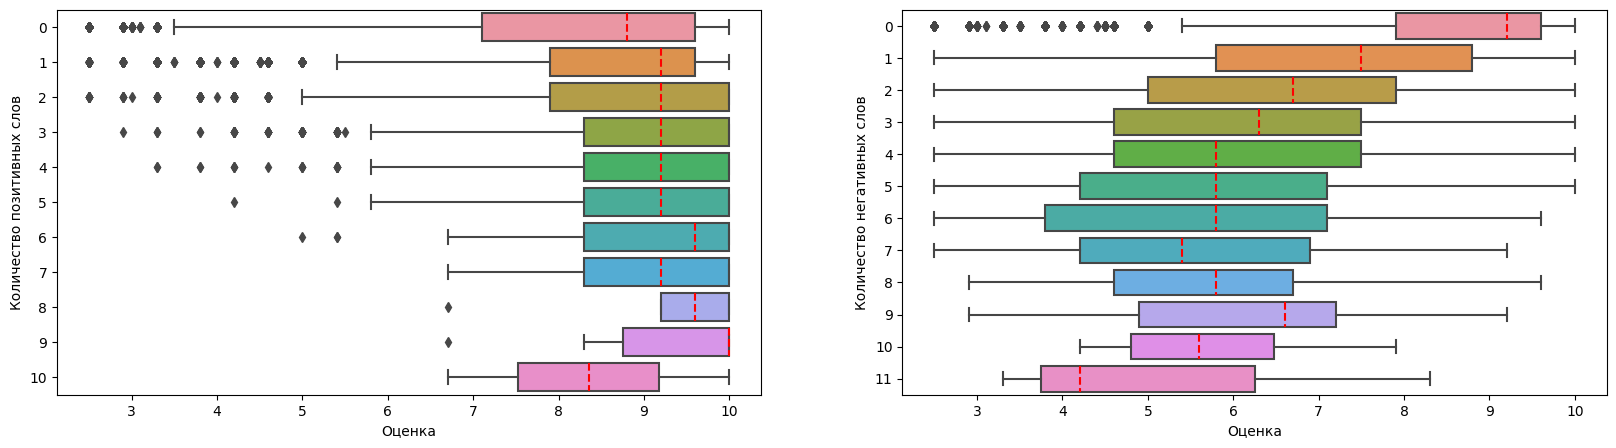

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.boxplot(train_data, x='reviewer_score', y='positiv_emo_words', orient='h', medianprops={'color':'red', 'linestyle':'--'}, ax=axes[0])
axes[0].set(xlabel='Оценка', ylabel='Количество позитивных слов')
sns.boxplot(train_data, x='reviewer_score', y='negativ_emo_words', orient='h', medianprops={'color':'red', 'linestyle':'--'}, ax=axes[1])
axes[1].set(xlabel='Оценка', ylabel='Количество негативных слов');

Из распределений заметна зависимость оценки от количества негативных слов

А теперь применим библиотеки для анализа текстов и проведём анализ настроений отзывов с их помощью.

In [ ]:
'''for i in range(train_data.shape[0]):
    if (len(train_data.at[i, 'negative_review'].split()) == 2):
        print(train_data.at[i, 'negative_review'])'''

"for i in range(train_data.shape[0]):\n    if (len(train_data.at[i, 'negative_review'].split()) == 2):\n        print(train_data.at[i, 'negative_review'])"

Для начала необходимо изменить некоторые отзывы, т.к. применяемые библиотеки не совсем правильно их оценивают.

Например: в позитивных отзывах огромное количество 'no positive', очевидно что это нейтральный отзыв, но из за слова 'no' в начале, оно расценивается библиотеками как негативное.

In [ ]:
def review_change(train_data):
    for i in range(train_data.shape[0]):
        if (len(train_data.at[i, 'positive_review'].split()) < 3) and (train_data.at[i, 'positive_review'].find('no positive')+1):
            train_data.at[i, 'positive_review'] = 'neutral'
        if (len(train_data.at[i, 'positive_review'].split()) == 2) and (train_data.at[i, 'positive_review'].find('the ')+1):
            train_data.at[i, 'positive_review'].replace('the', 'good')
        if (len(train_data.at[i, 'positive_review'].split()) < 2) and (train_data.at[i, 'positive_review'].find('everything')+1):
            train_data.at[i, 'positive_review'] = 'good'
        if (len(train_data.at[i, 'positive_review'].split()) < 2) and (train_data.at[i, 'positive_review'].find('nothing')+1):
            train_data.at[i, 'positive_review'] = 'neutral'
        if (len(train_data.at[i, 'positive_review'].split()) < 2) and (train_data.at[i, 'positive_review'].find('loc')+1):
            train_data.at[i, 'positive_review'] = 'good location'
        if (len(train_data.at[i, 'positive_review'].split()) < 2) and (train_data.at[i, 'positive_review'].find('staff')+1):
            train_data.at[i, 'positive_review'] = 'good staff'
        if (len(train_data.at[i, 'positive_review'].split()) < 2) and (train_data.at[i, 'positive_review'].find('yes')+1):
            train_data.at[i, 'positive_review'] = 'good'
        if (len(train_data.at[i, 'positive_review'].split()) < 2) and (train_data.at[i, 'positive_review'].find('breakfast')+1):
            train_data.at[i, 'positive_review'] = 'good breakfast'
        if (len(train_data.at[i, 'positive_review'].split()) < 2) and (train_data.at[i, 'positive_review'].find('position')+1):
            train_data.at[i, 'positive_review'] = 'good position'
        if (len(train_data.at[i, 'positive_review'].split()) < 2) and (train_data.at[i, 'positive_review'].find('room')+1):
            train_data.at[i, 'positive_review'] = 'good room'
        if (len(train_data.at[i, 'positive_review'].split()) < 2) and (train_data.at[i, 'positive_review'].find('service')+1):
            train_data.at[i, 'positive_review'] = 'good service'
        if (len(train_data.at[i, 'positive_review'].split()) < 2) and (train_data.at[i, 'positive_review'].find('bed')+1):
            train_data.at[i, 'positive_review'] = 'good bed'
        if (len(train_data.at[i, 'positive_review'].split()) < 2) and (train_data.at[i, 'positive_review'].find('all')+1):
            train_data.at[i, 'positive_review'] = 'good'
        if (len(train_data.at[i, 'positive_review'].split()) < 2) and (train_data.at[i, 'positive_review'].find('leaving')+1):
            train_data.at[i, 'positive_review'] = 'good leaving'
        if (len(train_data.at[i, 'positive_review'].split()) < 2) and (train_data.at[i, 'positive_review'].find('decor')+1):
            train_data.at[i, 'positive_review'] = 'good decor'
        if (len(train_data.at[i, 'positive_review'].split()) < 2) and (train_data.at[i, 'positive_review'].find('clean')+1):
            train_data.at[i, 'positive_review'] = 'good clean'
        if (len(train_data.at[i, 'positive_review'].split()) < 2) and (train_data.at[i, 'positive_review'].find('comfort')+1):
            train_data.at[i, 'positive_review'] = 'good comfort'
        if (len(train_data.at[i, 'positive_review'].split()) < 2) and (train_data.at[i, 'positive_review'].find('spa')+1):
            train_data.at[i, 'positive_review'] = 'good spa'
        if (len(train_data.at[i, 'positive_review'].split()) < 2) and (train_data.at[i, 'positive_review'].find('view')+1):
            train_data.at[i, 'positive_review'] = 'good view'
        if (len(train_data.at[i, 'positive_review'].split()) < 2) and (train_data.at[i, 'positive_review'].find('bath')+1):
            train_data.at[i, 'positive_review'] = 'good bathroom'
        
        
        
        if (len(train_data.at[i, 'negative_review'].split()) < 3) and (train_data.at[i, 'negative_review'].find('no negative')+1):
            train_data.at[i, 'negative_review'] = 'neutral'
        if (len(train_data.at[i, 'negative_review'].split()) == 2) and (train_data.at[i, 'negative_review'].find('the ')+1):
            train_data.at[i, 'negative_review'].replace('the', 'bad')
        if (len(train_data.at[i, 'negative_review'].split()) == 2) and (train_data.at[i, 'negative_review'].find('slow')+1):
            train_data.at[i, 'negative_review'].replace('slow', 'bad')
        if (len(train_data.at[i, 'negative_review'].split()) == 2) and (train_data.at[i, 'negative_review'].find('expensive')+1):
            train_data.at[i, 'negative_review'].replace('expensive', 'bad expensive')
        if (len(train_data.at[i, 'negative_review'].split()) == 2) and (train_data.at[i, 'negative_review'].find('air')+1):
            train_data.at[i, 'negative_review'].replace('air', 'bad air')
        if (len(train_data.at[i, 'negative_review'].split()) < 2) and (train_data.at[i, 'negative_review'].find('nothing')+1):
            train_data.at[i, 'negative_review'] = 'neutral'
        if (len(train_data.at[i, 'negative_review'].split()) < 2) and (train_data.at[i, 'negative_review'].find('everything')+1):
            train_data.at[i, 'negative_review'] = 'bad'
        if (len(train_data.at[i, 'negative_review'].split()) < 2) and (train_data.at[i, 'negative_review'].find('price')+1):
            train_data.at[i, 'negative_review'] = 'bad price'
        if (len(train_data.at[i, 'negative_review'].split()) < 3) and (train_data.at[i, 'negative_review'].find('small')+1):
            train_data.at[i, 'negative_review'] = 'bad small'
        if (len(train_data.at[i, 'negative_review'].split()) < 2) and (train_data.at[i, 'negative_review'].find('leaving')+1):
            train_data.at[i, 'negative_review'] = 'bad leaving'
        if (len(train_data.at[i, 'negative_review'].split()) < 2) and (train_data.at[i, 'negative_review'].find('breakfast')+1):
            train_data.at[i, 'negative_review'] = 'bad breakfast'
        if (len(train_data.at[i, 'negative_review'].split()) < 2) and (train_data.at[i, 'negative_review'].find('pillows')+1):
            train_data.at[i, 'negative_review'] = 'bad pillows'
        if (len(train_data.at[i, 'negative_review'].split()) < 2) and (train_data.at[i, 'negative_review'].find('staff')+1):
            train_data.at[i, 'negative_review'] = 'bad staff'
        if (len(train_data.at[i, 'negative_review'].split()) < 2) and (train_data.at[i, 'negative_review'].find('bathroom')+1):
            train_data.at[i, 'negative_review'] = 'bad bathroom'
        if (len(train_data.at[i, 'negative_review'].split()) < 2) and (train_data.at[i, 'negative_review'].find('all')+1):
            train_data.at[i, 'negative_review'] = 'bad all'
        if (len(train_data.at[i, 'negative_review'].split()) < 2) and (train_data.at[i, 'negative_review'].find('location')+1):
            train_data.at[i, 'negative_review'] = 'bad location'
        if (len(train_data.at[i, 'negative_review'].split()) < 2) and (train_data.at[i, 'negative_review'].find('nil')+1):
            train_data.at[i, 'negative_review'] = 'neutral'
        if (len(train_data.at[i, 'negative_review'].split()) < 2) and (train_data.at[i, 'negative_review'].find('none')+1):
            train_data.at[i, 'negative_review'] = 'neutral'
        if (len(train_data.at[i, 'negative_review'].split()) < 2) and (train_data.at[i, 'negative_review'].find('parking')+1):
            train_data.at[i, 'negative_review'] = 'bad parking'
        if (len(train_data.at[i, 'negative_review'].split()) < 2) and (train_data.at[i, 'negative_review'].find('food')+1):
            train_data.at[i, 'negative_review'] = 'bad food'
        if (len(train_data.at[i, 'negative_review'].split()) < 2) and (train_data.at[i, 'negative_review'].find('view')+1):
            train_data.at[i, 'negative_review'] = 'bad view'
    
    return train_data

train_data = review_change(train_data)

In [ ]:
def text_blob_analyz(data):
    def polarity(review):
        sent = TextBlob(review)
        return sent.sentiment[0]
    def subjectivity(review):
        sent = TextBlob(review)
        return sent.sentiment[1]
    data['pos_polarity'] = data['positive_review'].apply(polarity)
    data['pos_subjectivity'] = data['positive_review'].apply(subjectivity)
    data['neg_polarity'] = data['negative_review'].apply(polarity)
    data['neg_subjectivity'] = data['negative_review'].apply(subjectivity)
    data['pos_neg_polar_comp'] = data['pos_polarity'] + data['neg_polarity']
    data['pos_neg_subj_comp'] = data['pos_subjectivity'] + data['neg_subjectivity']
    
    return data

train_data = text_blob_analyz(train_data)

In [ ]:
def nltk_analyz(data):
    sia = SentimentIntensityAnalyzer()
    
    data['neg_scores'] = data['negative_review'].apply(lambda x: sia.polarity_scores(x))
    data['pos_scores'] = data['positive_review'].apply(lambda x: sia.polarity_scores(x))

    # формируем новые признаки:
    data['neg_nltk_neg'] = data['neg_scores'].apply(lambda x: x['neg'])
    data['neg_nltk_neu'] = data['neg_scores'].apply(lambda x: x['neu'])
    data['neg_nltk_pos'] = data['neg_scores'].apply(lambda x: x['pos'])
    data['neg_nltk_compound'] = data['neg_scores'].apply(lambda x: x['compound'])

    data['pos_nltk_neg'] = data['pos_scores'].apply(lambda x: x['neg'])
    data['pos_nltk_neu'] = data['pos_scores'].apply(lambda x: x['neu'])
    data['pos_nltk_pos'] = data['pos_scores'].apply(lambda x: x['pos'])
    data['pos_nltk_compound'] = data['pos_scores'].apply(lambda x: x['compound'])
    
    data = data.drop(['neg_scores', 'pos_scores'], axis=1)
    
    return data

train_data = nltk_analyz(train_data)

In [ ]:
def afinn_scoring(data):
    afinn = Afinn()
    data['pos_afinn_score'] = data['positive_review'].apply(lambda x: afinn.score(x))
    data['neg_afinn_score'] = data['negative_review'].apply(lambda x: afinn.score(x))
       
    return data

In [ ]:
train_data = afinn_scoring(train_data)

In [ ]:
# различные дополнительные признаки (сочетания уже имеющихся), которые немного улучшают метрику
def additional_feature_engineering_2(data):
    data['pos_neg_dev_emo'] = (data['positiv_emo_words']+1) / (data['negativ_emo_words']+1)                         # отношение количества слов с позитивным и негативным окрасом
    data['neg_emo_dev_r_t_n_w_c'] = (data['negativ_emo_words']+1) / (data['review_total_negative_word_counts']+1)   # отношение количества слов с негативным окрасом, к общему количеству слов в отзыве
    data['pos_emo_dev_r_t_p_w_c'] = (data['positiv_emo_words']+1) / (data['review_total_positive_word_counts']+1)   # --//-- с позитивным окрасом
    data['0_pos_neg'] = (data['pos_emo_dev_r_t_p_w_c']+1) / (data['neg_emo_dev_r_t_n_w_c']+1)                       # тяжело интерпритировать, отношение двух предидущих признаков
    data = data.drop(['pos_emo_dev_r_t_p_w_c', 'neg_emo_dev_r_t_n_w_c'], axis=1)                                    # удаление этих признаков улучшело метрику
    
    data['pos_neg_ratio_quality'] = (data['positiv_quality_room']+1) / (data['negativ_quality_room']+1)             # отношение количества слов качественно описывающих номера

    data['pos_pol_subj'] = abs(data['pos_polarity']) - abs(data['pos_subjectivity'])                                # разница между показателями TextBlob
    data['neg_pol_subj'] = abs(data['neg_polarity']) - abs(data['neg_subjectivity'])                                # --//--
    #
    data['0_pos*neg_afinn_score'] = data['pos_afinn_score'] * data['neg_afinn_score']                               
    # вычислим средние показатели по всем библиотекам
    data['0_pos_avg_models'] = (data['pos_afinn_score'] + data['pos_nltk_compound'] + data['pos_polarity'] + data['pos_subjectivity']) / 4
    data['0_neg_avg_models'] = (data['neg_afinn_score'] + data['neg_nltk_compound'] + data['neg_polarity'] + data['neg_subjectivity']) / 4
    #
    data['0_pos*neg_avg_models'] = abs(data['0_pos_avg_models']) - abs(data['0_neg_avg_models'])                    # разница между средними показателями
    
    return data

train_data = additional_feature_engineering_2(train_data)


---

---

## Дополнительные преобразования (после здачи проекта)

In [ ]:
def addit_feature_engene_1(data):
    
    # объединяем положительные и отрицательные отзывы
    data["review"] = data["negative_review"] + data["positive_review"]

    # создаём метку для плохого отзыва (1 - True, 0 - False)
    #data["is_bad_review"] = data["reviewer_score"].apply(lambda x: 1 if x < 5 else 0)

    return data

In [ ]:
train_data = addit_feature_engene_1(train_data)

In [ ]:
# использование wordnet для анализа частей речи


from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer


def addit_feature_engene_2(data):
    def clean_text(text):
        # приводим к нижнему регистру
        text = text.lower()
        # разделение текста на слова и удаление знаков препинания
        text = [word.strip(string.punctuation) for word in text.split(" ")]
        # удаляем цифры из текста
        text = [word for word in text if not any(c.isdigit() for c in word)]
        # удаляем стоп-слова
        stop = stopwords.words('english')
        text = [x for x in text if x not in stop]
        # удаляем пустые токены
        text = [t for t in text if len(t) > 0]
        # pos tag text
        pos_tags = pos_tag(text)
        # лемматизация текста
        text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
        # удаляем слова из одной буквы
        text = [t for t in text if len(t) > 1]
        # объединяем текст
        text = " ".join(text)
        return(text)

    # очистка текстовых данных
    data["review_clean"] = data["review"].apply(lambda x: clean_text(x))
    
    return data

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train_data = addit_feature_engene_2(train_data)

In [ ]:
# анализ тональности (настроения) текста отзыва

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

def addit_feature_engene_3(data):
    sid = SentimentIntensityAnalyzer()
    data["sentiments"] = data["review"].apply(lambda x: sid.polarity_scores(x))
    data = pd.concat([data.drop(['sentiments'], axis=1), data['sentiments'].apply(pd.Series)], axis=1)
    
    return data

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
train_data = addit_feature_engene_3(train_data)

In [ ]:
def addit_feature_engene_4(data):
    # создадим признак кол-во символов в отзыве
    data["nb_chars"] = data["review"].apply(lambda x: len(x))

    # создадим признак кол-во слов в отзыве
    data["nb_words"] = data["review"].apply(lambda x: len(x.split(" ")))
    
    return data

In [ ]:
train_data = addit_feature_engene_4(train_data)

In [ ]:
# векторизация слов с помощью doc2vec и создание нового признака

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def addit_feature_engene_5(data):
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data["review_clean"].apply(lambda x: x.split(" ")))]

    # обучение модели Doc2Vec с помощью текстовых данных
    model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

    # преобразуем каждый документ в вектор данных
    doc2vec_df = data["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
    doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
    data = pd.concat([data, doc2vec_df], axis=1)
    
    return data

In [ ]:
train_data = addit_feature_engene_5(train_data)

In [ ]:
# создание признака tf-idfs (оценка важности слова в тексте)
from sklearn.feature_extraction.text import TfidfVectorizer

def addit_feature_engene_6(data):
    tfidf = TfidfVectorizer(min_df = 10, max_features=100) ############## изменил
    tfidf_result = tfidf.fit_transform(data["review_clean"]).toarray()
    tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
    tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
    tfidf_df.index = data.index
    data = pd.concat([data, tfidf_df], axis=1)
    
    return data

In [ ]:
train_data = addit_feature_engene_6(train_data)

---

---

#### <CENTER>Признак tags</CENTER>

Переходим к самому объёмному признаку по содержащейся в нём информации.

Для начала взглянем на все уникальные теги и количество записей где они используются.

In [ ]:
all_tags_dict = {}

for tags in train_data['tags']:
    tags = tags.replace("[' ", '')
    tags = tags.replace(" ']", '')
    list_tags = tags.split(" ', ' ")
    for tag in list_tags:
        if tag not in all_tags_dict.keys():
            all_tags_dict[tag] = 1
        else:
            all_tags_dict[tag] += 1
sorted_tags = dict(sorted(all_tags_dict.items(), key=lambda item: item[1], reverse=True))
cnt = 0
for key in sorted_tags:
    if cnt < 20:
        print(key+':',sorted_tags[key])
        cnt += 1
    else:
        break
    

Leisure trip: 313353
Submitted from a mobile device: 230608
Couple: 189046
Stayed 1 night: 145296
Stayed 2 nights: 100176
Solo traveler: 81166
Stayed 3 nights: 71940
Business trip: 61934
Group: 49057
Family with young children: 45810
Stayed 4 nights: 35708
Double Room: 26386
Standard Double Room: 24150
Superior Double Room: 23518
Family with older children: 19787
Deluxe Double Room: 18612
Double or Twin Room: 16824
Stayed 5 nights: 15592
Standard Double or Twin Room: 13058
Classic Double Room: 12604


Уникальных тегов огромное количество, изучив их структуру, можно выделить такие признаки: 

количество мест номера(single, double = twin, triple, quadruple), количество ночей, класс номера(Standard=Classic(c), Superior(s), Executive(e), Deluxe(d), Luxury(l), Business(b), Family(f), Premium(p)), тип номера(Suite, Junior Suite, Apartment, studio, room), королевский размер кровати(Queen, King,) колличество людей(2 Adults 1 Child = 3), семья с детьми(child), с животными, номер с видом, поездка на отдых, бизнес поездка.

In [ ]:
def tags_func(data):
    """Функция преобразования признака tags
       Создаём признаки на основе тегов.   
    Args:
        data (DataFrame): Изначальный датасет
    Returns:
        DataFrame: преобразованный датасет
    """
    # список признаков которые мы возьмём из тегов
    new_columns = ['leisure_trip', 'business_trip', 'with_view', 'with_pet', 'with_child', 'people_count', 'nights_count', 'number_of_places', 'room_class', 'room_type', 'king_size']
    # цикл по списку признаков
    for colum in new_columns:
        
        def sep_distr_tags(tags_str):
            """Функция выделения необходимого признака
               из строки признака tags   
            Args:
                tags_str (string): строка из признака tags
            Returns:
                Значения для новых признаков
            """
            list_tags = tags_str.replace("[' ", '').replace(" ']", '').split(" ', ' ")
            
            if colum == 'leisure_trip':
                for i in list_tags:
                    if i.lower().find('leisure trip')+1:
                        return 1
            if colum == 'business_trip':
                for i in list_tags:
                    if i.lower().find('business trip')+1:
                        return 1
            if colum == 'with_pet':
                for i in list_tags:
                    if i.lower().find('with a pet')+1:
                        return 1
            if colum == 'with_view':
                for i in list_tags:
                    if i.lower().find('view')+1:
                        return 1
            if colum == 'with_child':
                for i in list_tags:
                    if i.lower().find('child')+1:
                        return 1
            if colum == 'nights_count':
                for i in list_tags:
                    if i.lower().find('stayed ')+1:
                        return int(i.split(' ')[1])
            if colum == 'people_count':
                for i in list_tags:
                    if i.lower().find('solo traveler')+1:
                        return 1
                    elif i.lower().find('couple')+1:
                        return 2
                    elif i.lower().find('adult')+1 and i.lower().find('child')+1:
                        summ = int(i[i.lower().find('adult')-2]) + int(i[i.lower().find('child')-2])
                        return summ
                    elif i.lower().find('adult')+1:
                        return int(i[i.lower().find('adult')-2])
                return 1
            if colum == 'king_size':
                for i in list_tags:
                    if i.lower().find('king')+1 or i.lower().find('queen')+1:
                        return 1
            if colum == 'room_class':
                classes = ['standard', 'classic', 'superior', 'executive', 'deluxe', 'luxury', 'business', 'family', 'premium']
                retur_clas = ''
                for i in list_tags:
                    if i.lower().find('business trip')+1 or i.lower().find('family with')+1:
                        continue
                    for clas in classes:
                        if i.lower().find(clas)+1:
                            if clas == 'standard':  # как я понял номера standard и classic, это в принципе одно и тоже
                                retur_clas += 'c'   # поэтому отнесём их к одному классу
                                continue
                            retur_clas += clas[0]
                if retur_clas == '':
                    return 'o'
                else:
                    sort_clas = sorted(retur_clas)  # обязательно сортируем маркеры классов чтобы избежать повторов,
                    sort_clas = ''.join(sort_clas)  # если классы указаны в разном порядке 
                    return sort_clas
            if colum == 'room_type':
                for i in list_tags:
                    if i.lower().find('junior suite')+1:    # указываем условия поиска типов
                        return 'junior suite'               # в нужном нам порядке чтобы
                    elif i.lower().find('suite')+1:         # выделить наиболее важный тип
                        return 'suite'                      # например из тега "double room family suite"
                    elif i.lower().find('apartment')+1:     # чтобы получить тип "suite"
                        return 'apartment'
                    elif i.lower().find('studio')+1:
                        return 'studio'
                    elif i.lower().find('room')+1:
                        return 'room'
                return 'unknown'
            if colum == 'number_of_places':
                for i in list_tags:
                    if i.lower().find('single')+1:
                        return 1
                    if i.lower().find('double')+1 or i.lower().find('twin')+1:
                        return 2
                    if i.lower().find('triple')+1:
                        return 3
                    if i.lower().find('quadruple')+1:
                        return 4
                return 1
            
            return 0
        # применяем нашу функцию в цикле, для каждого нового признака
        data[colum] = data['tags'].apply(sep_distr_tags)
    # возвращаем обновленный датасет
    return data

train_data = tags_func(train_data)
train_data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,business_trip,with_view,with_pet,with_child,people_count,nights_count,number_of_places,room_class,room_type,king_size
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,bad leaving,1,1994,staff were amazing,...,0,0,0,0,2,2,1,o,suite,0
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,2,1361,good location,...,1,0,0,0,2,1,2,c,room,0
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,no kettle in room,4,406,neutral,...,0,0,0,0,1,3,2,o,room,0


#### <CENTER>Признак days_since_review</CENTER>

In [ ]:
train_data['days_since_review'].head(3)

0    531 day
1    203 day
2    289 day
Name: days_since_review, dtype: object

Удалим слово 'day' и изменим тип данных на int

In [ ]:
def days_since_func(data):
    data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split(' ')[0]))
    return data

train_data = days_since_func(train_data)
train_data['days_since_review'].head(3)

0    531
1    203
2    289
Name: days_since_review, dtype: int64

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386496 entries, 0 to 386495
Columns: 180 entries, hotel_address to king_size
dtypes: datetime64[ns](1), float32(5), float64(137), int64(25), object(12)
memory usage: 523.4+ MB


### Кодирование признаков

Признаки которые нуждаются в кодировании: country, room_class, room_type, review_year.

Признак country закодируем однократным кодированием.

Признак review_year и room_type, порядковым кодированием, в порядке: room, studio, Apartment, Junior Suite, Suite.

Признак room_class по идее тоже должен быть порядково закодирован, но проблема установить этот порядок, а также имеются сочетания классов, поэтому применим двоичное кодирование.

In [ ]:
# импортируем библиотеку для работы с кодировщиками
import category_encoders as ce 

In [ ]:
train_data['review_year'].value_counts()

2016    198071
2017    117574
2015     70851
Name: review_year, dtype: int64

In [ ]:
def encoding_feature_func(data):
    """Функция кодирования признаков.   
    Args:
        data (DataFrame): Изначальный датасет
    Returns:
        DataFrame: преобразованный датасет
    """
    # кодируем признак room_type
    # к сожалению я так и не разобрался как с помощью OrdinalEncoder закодировать в нужном мне порядке, поэтому кодируем вручную.
    roo_typ = [('unknown', 0), ('room', 1), ('studio', 2), ('apartment', 3), ('junior suite', 4), ('suite', 5)]
    roo_typ = pd.DataFrame(roo_typ, columns=['room_type', 'room_type_encode'])   # создаём датасет с типами комнат и порядковыми номерами
    data = data.join(roo_typ.set_index('room_type'), on='room_type', how='left') # и джойним слева
    # кодируем признак country
    encoder = ce.OneHotEncoder(cols=['country'], use_cat_names=True)             # указываем столбец для кодирования
    type_bin = encoder.fit_transform(data['country'])
    data = pd.concat([data, type_bin], axis=1)
    # кодируем признак room_class
    bin_encoder = ce.BinaryEncoder(cols=['room_class'])                          # указываем столбец для кодирования
    type_bin = bin_encoder.fit_transform(data['room_class'])
    data = pd.concat([data, type_bin], axis=1)
    # кодируем признак review_year
    year_df = [(2015, 1), (2016, 2), (2017, 3), (2018, 4), (2019, 5)]
    year_df = pd.DataFrame(year_df, columns=['review_year', 'review_year_encode'])
    data = data.join(year_df.set_index('review_year'), on='review_year', how='left') # и джойним слева
    
    return data

train_data = encoding_feature_func(train_data)
train_data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,country_Netherlands,country_Italy,country_Austria,country_Spain,room_class_0,room_class_1,room_class_2,room_class_3,room_class_4,review_year_encode
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,bad leaving,1,1994,staff were amazing,...,0,0,0,0,0,0,0,0,1,2
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,2,1361,good location,...,0,0,0,0,0,0,0,1,0,3


### Нормализация, стандартизация

Так как в начале мы не очищали данные от выбросов, применим к данным нормализацию методом RobustScaler.

In [ ]:
# Импортируем библиотеку для нормализации, стандартизации.
from sklearn import preprocessing

In [ ]:
'''def norm_stand_func(data):
    """Функция нормализации/стандартизации признаков.   
    Args:
        data (DataFrame): Изначальный датасет
    Returns:
        DataFrame: преобразованный датасет
    """
    norm_data = data[['average_score', 'additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 
                    'total_number_of_reviews_reviewer_has_given', 'days_since_review','quality_of_life', 'avg_month_salary']]
    # Копируем названия столбцов, которые теряются при использовании fit_transform()
    col_names = list(norm_data.columns)
    # инициализируем нормализатор RobustScaler
    r_scaler = preprocessing.RobustScaler()
    # кодируем исходный датасет
    df_r = r_scaler.fit_transform(norm_data)
    # Преобразуем промежуточный датасет в полноценный датафрейм
    df_r = pd.DataFrame(df_r, columns=col_names)

    data[['average_score', 'additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 
        'total_number_of_reviews_reviewer_has_given', 'days_since_review','quality_of_life', 'avg_month_salary']] = df_r
    
    return data''';

#train_data = norm_stand_func(train_data)

Из экспериментов стало ясно, что нормализация и стандартизация не улучшает метрику.

### Отбор признаков

Для начала просто удалим все не числовые, использованные признаки которые нам больше не нужны.

In [ ]:
# функция удаления ненужных признаков
def drop_not_numeric_func(data):
    drop_colum_list = ['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'country', 'city', 'room_class', 'room_type', 'review_year']
    data = data.drop(drop_colum_list, axis=1)
    return data

train_data = drop_not_numeric_func(train_data)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386496 entries, 0 to 386495
Columns: 181 entries, additional_number_of_scoring to review_year_encode
dtypes: float32(5), float64(137), int64(37), object(2)
memory usage: 526.3+ MB


In [ ]:
# разделим признаки на непрерывные и категориальные, не включая наш таргет reviewer_score
# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 'additional_number_of_scoring', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 
            'days_since_review', 'quality_of_life', 'avg_month_salary', 'positiv_emo_words', 'negativ_emo_words', '0_review_word_counts_ratio', 'average_score', 
            'reviewer_score', '0_a_n_o_s__t_n_o_r', 'positiv_quality_room', 'negativ_quality_room', 'pos_polarity', 'pos_subjectivity', 'neg_polarity', 'neg_subjectivity', 'pos_neg_polar_comp', 
            'pos_neg_subj_comp', 'neg_nltk_neg', 'neg_nltk_neu', 'neg_nltk_pos', 'neg_nltk_compound', 'pos_nltk_neg', 'pos_nltk_neu', 'pos_nltk_pos', 'pos_nltk_compound', 'pos_afinn_score', 
            'neg_afinn_score', 'pos_neg_dev_emo', '0_pos_neg', 'pos_neg_ratio_quality', 'pos_pol_subj', 'neg_pol_subj', '0_pos*neg_afinn_score', '0_pos_avg_models', '0_neg_avg_models', '0_pos*neg_avg_models', 
            ]

# категориальные признаки
cat_cols = ['lat', 'lng', 'review_month', 'review_quarter', 'country_equal_nation', 'leisure_trip', 'business_trip', 'with_view', 'with_pet', 'with_child', 'number_of_places', 
            'king_size', 'room_type_encode', 'country_United Kingdom', 'country_France', 'country_Netherlands', 'country_Italy', 'country_Austria', 'country_Spain', 
            'review_year_encode', 'reviewer_score', 'people_count', 'nights_count']

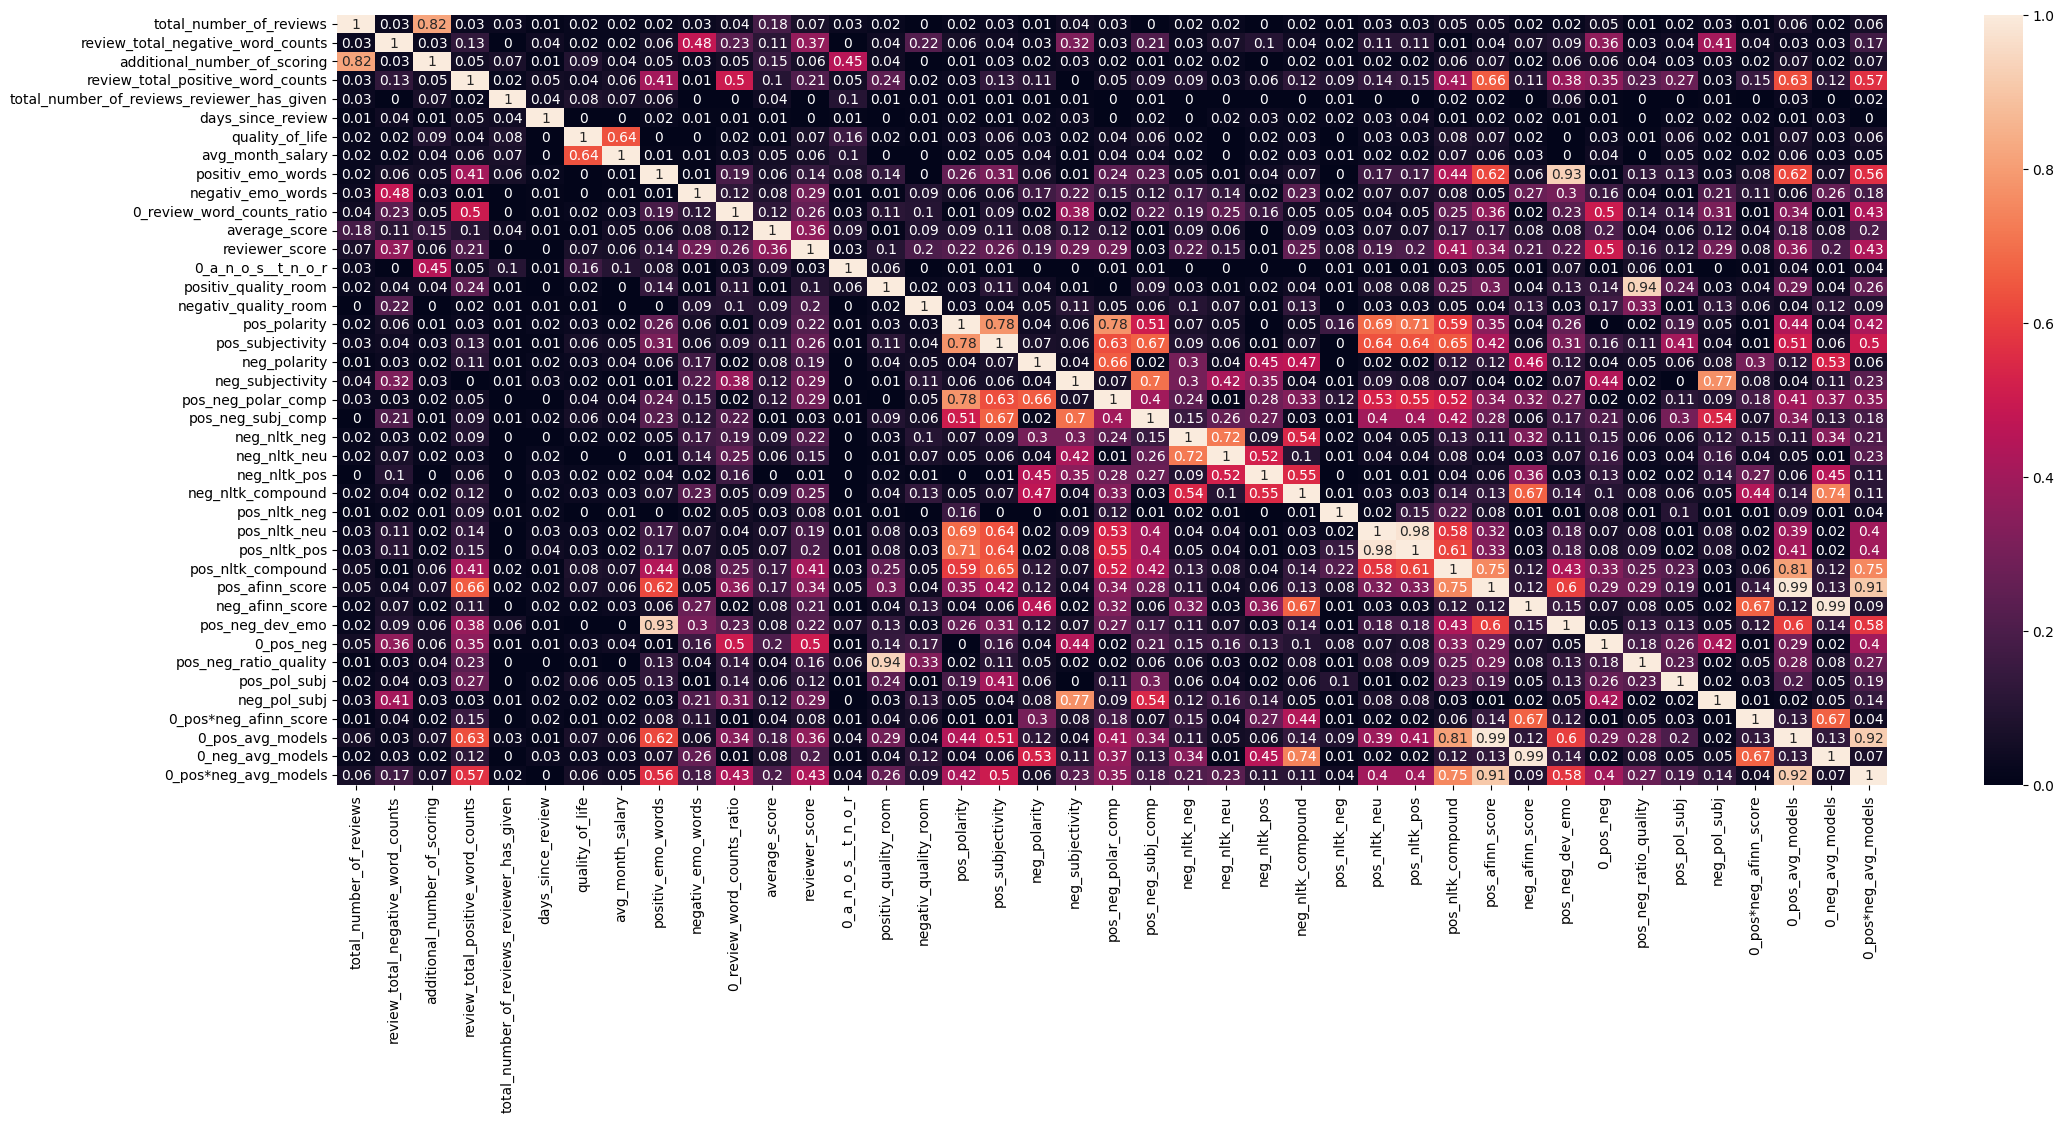

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.heatmap(train_data[num_cols].corr().abs().round(2), annot=True);

Удаляем additional_number_of_scoring, остальные коррелирующие признаки я пробовал удалять, но метрика не улучшалась.

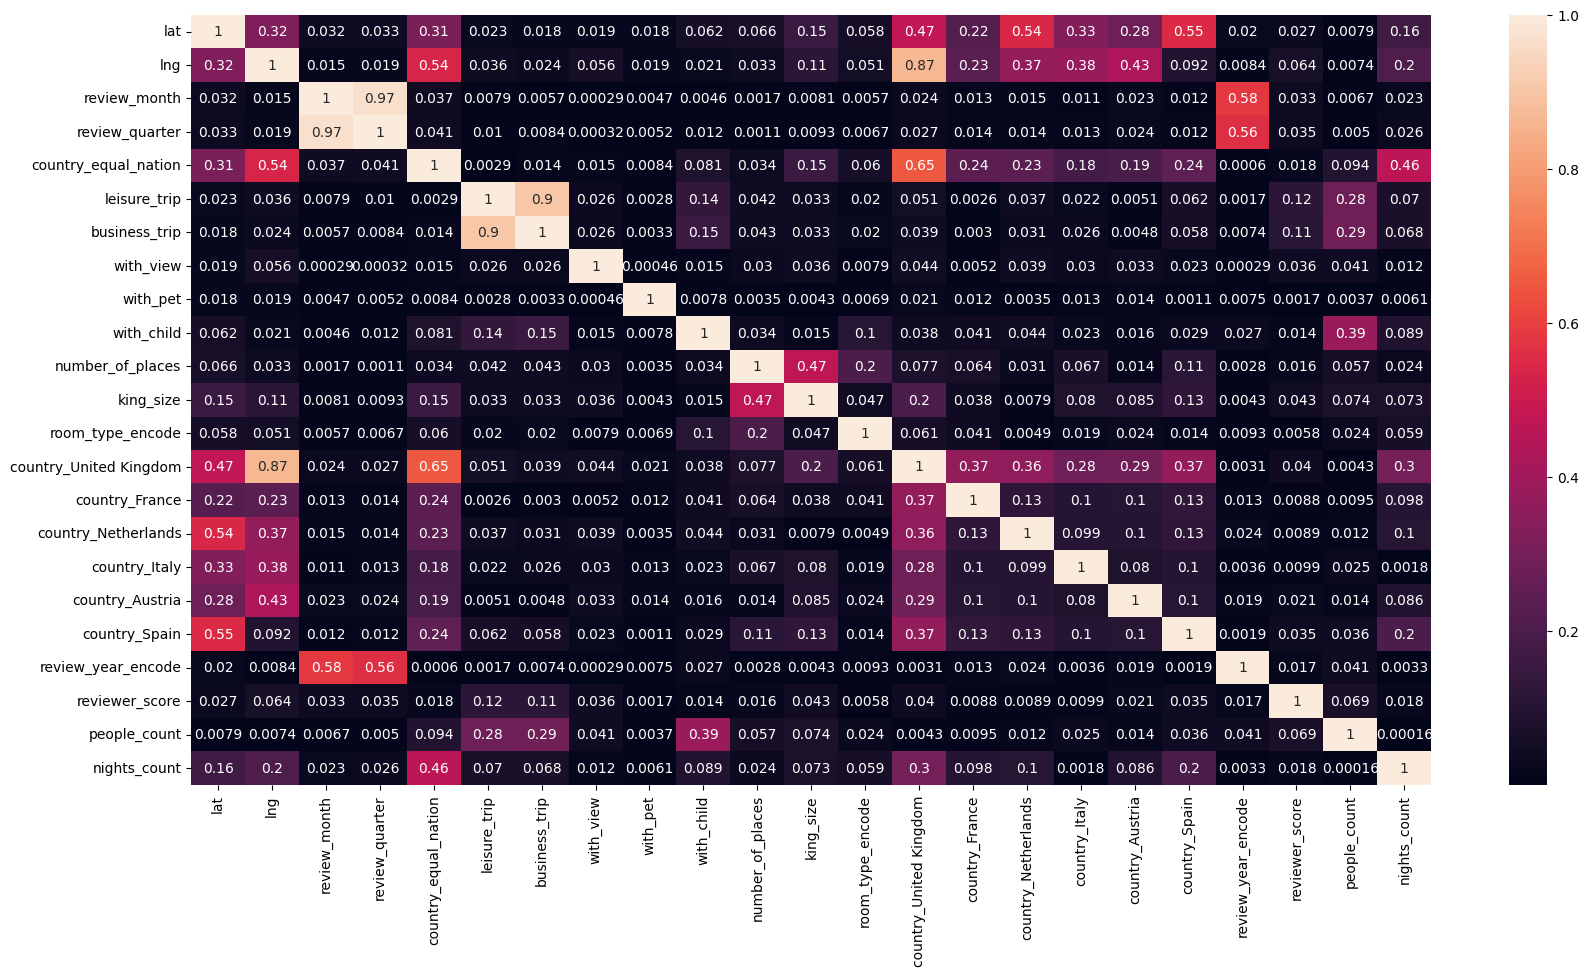

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.heatmap(train_data[cat_cols].corr(method = 'spearman').abs(), annot=True);

Удаляем review_month, и country_United Kingdom, т.к. информация по этому признаку не теряется(если по всем странам нули, значит это United Kingdom).

In [ ]:
# функция удаления мультиколлинеарных признаков
def drop_multicoll_func(data):
    drop_colum_list = ['additional_number_of_scoring', 'review_month', 'country_United Kingdom'] #
    data = data.drop(drop_colum_list, axis=1)
    return data

train_data = drop_multicoll_func(train_data)

***Разделим выборку на X и y***

In [ ]:
y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

**И проведём оценку значимости наших признаков для таргета.**

Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.

In [ ]:
num_cols.remove('additional_number_of_scoring')
num_cols.remove('reviewer_score')
cat_cols.remove('review_month')
cat_cols.remove('country_United Kingdom')
cat_cols.remove('reviewer_score')
cat_cols.remove('lng')

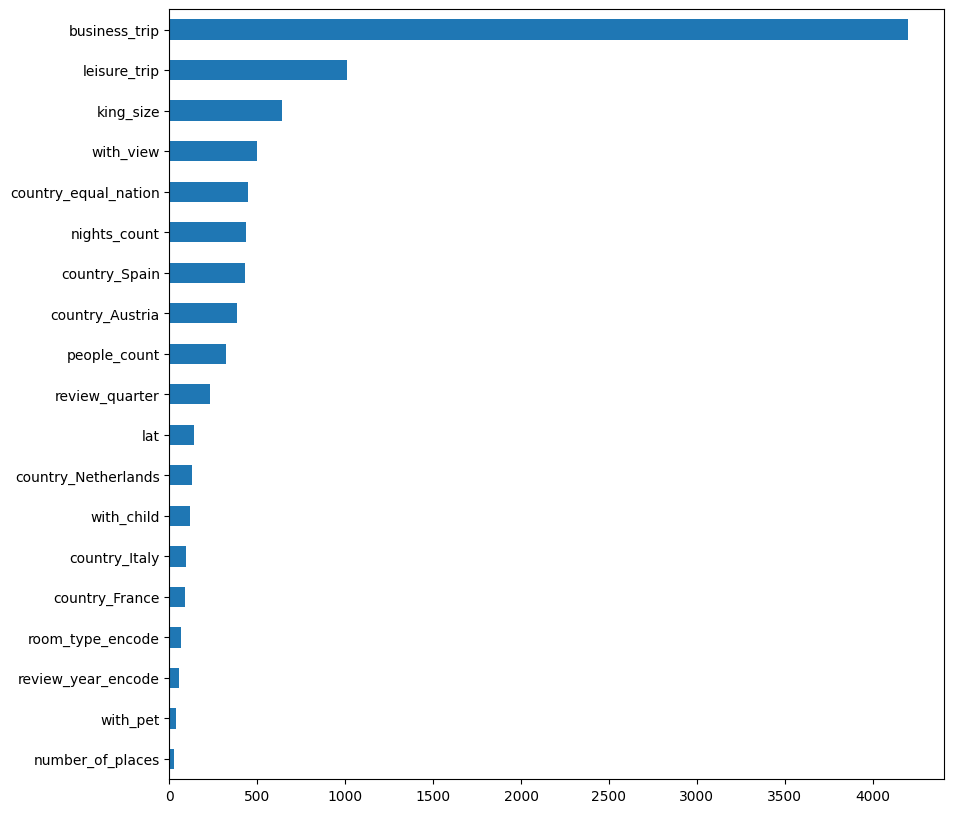

In [ ]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

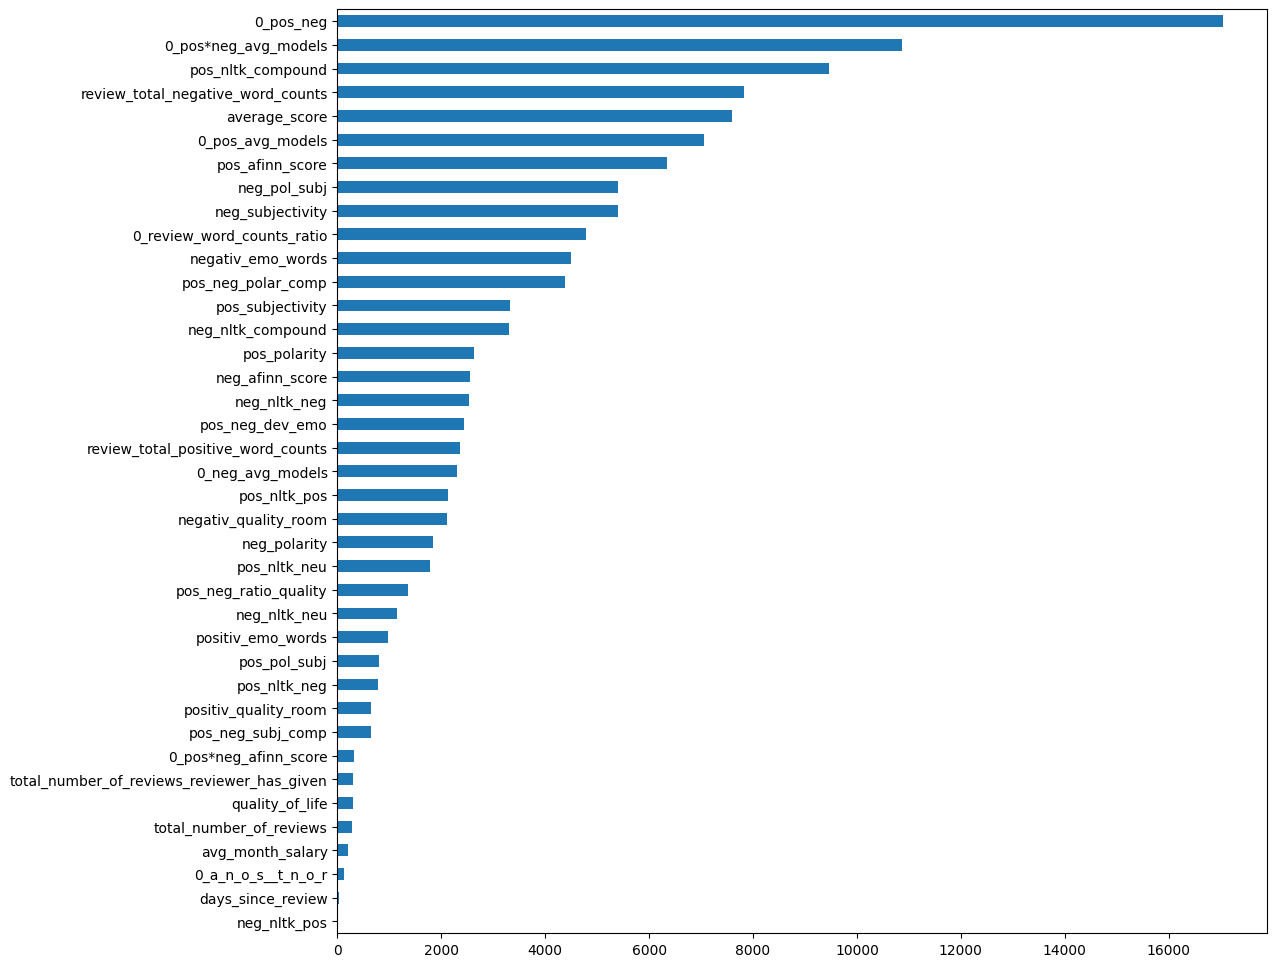

In [ ]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
fig, ax = plt.subplots(figsize=(12, 12))
imp_num.plot(kind = 'barh');

---

## Моделирование

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386496 entries, 0 to 386495
Columns: 178 entries, average_score to review_year_encode
dtypes: float32(5), float64(137), int64(34), object(2)
memory usage: 517.5+ MB


In [ ]:
train_data_2 = train_data.copy()

In [ ]:
train_data_2 = train_data_2.drop(['review', 'review_clean'], axis=1)

In [ ]:
y = train_data_2.reviewer_score.values            # наш таргет
X = train_data_2.drop(['reviewer_score'], axis=1)

# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, verbose=1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.0min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished


In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

#0.122538 train_data_2['0_pos*neg_afinn_score'] = train_data_2['pos_afinn_score'] * train_data_2['neg_afinn_score']
#0.122507 train_data_2['0_pos_avg_models'] = (train_data_2['pos_afinn_score'] + train_data_2['pos_nltk_compound'] + train_data_2['pos_polarity'] + train_data_2['pos_subjectivity']) / 4
#0.122485
#0.121278
#0.121148
#0.121091

MAPE: 0.11861998253952352


<Axes: >

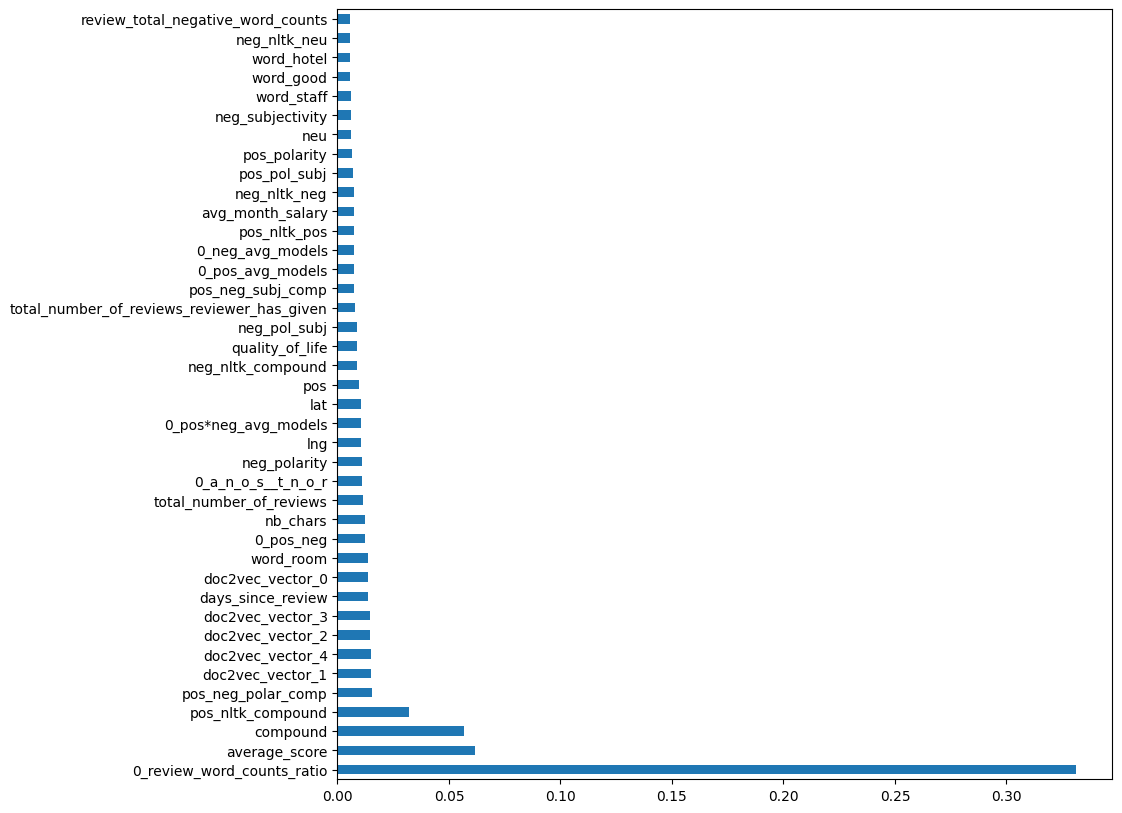

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(40).plot(kind='barh')

---

## Соревнование

In [ ]:
test_data = df_test.copy()

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [ ]:
def predict_feature_engineering(data):
    data = data.fillna(0)
    data = hotel_address_func(data)
    print('hotel_address_func complete')
    data = review_date_func(data)
    print('review_date_func complete')
    data = reviewer_nationality_func(data)
    print('reviewer_nationality_func complete')
    data = additional_feature_engineering(data)
    print('additional_feature_engineering complete')
    data = review_word_count(data)
    print('review_word_count complete')
    data = pos_neg_rev_func(data)
    print('pos_neg_rev_func complete')
    data = review_change(data)
    print('review_change complete')
    data = text_blob_analyz(data)
    print('text_blob_analyz complete')
    data = nltk_analyz(data)
    print('nltk_analyz complete')
    data = afinn_scoring(data)
    print('afinn_scoring complete')
    data = additional_feature_engineering_2(data)
    print('additional_feature_engineering_2 complete')
    
    ########################################
    data = addit_feature_engene_1(data)
    data = addit_feature_engene_2(data)
    data = addit_feature_engene_3(data)
    data = addit_feature_engene_4(data)
    data = addit_feature_engene_5(data)
    data = addit_feature_engene_6(data)
    #######################################
    
    data = tags_func(data)
    print('tags_func complete')
    data = days_since_func(data)
    print('days_since_func complete')
    data = encoding_feature_func(data)
    print('encoding_feature_func complete')
    #data = norm_stand_func(data)#
    data = drop_not_numeric_func(data)
    print('drop_not_numeric_func complete')
    data = drop_multicoll_func(data)
    print('drop_multicoll_func complete')
    
    
    
    return data

In [ ]:
# производим все преобразования  с соревновательным датасетом
test_data = predict_feature_engineering(test_data)

hotel_address_func complete
review_date_func complete
reviewer_nationality_func complete
additional_feature_engineering complete
review_word_count complete
pos_neg_rev_func complete
review_change complete
text_blob_analyz complete
nltk_analyz complete
afinn_scoring complete
additional_feature_engineering_2 complete
tags_func complete
days_since_func complete
encoding_feature_func complete
drop_not_numeric_func complete
drop_multicoll_func complete


In [ ]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,review_quarter,country_equal_nation,...,country_Netherlands,country_Spain,country_France,country_Austria,room_class_0,room_class_1,room_class_2,room_class_3,room_class_4,review_year_encode
111396,9.2,19,1436,3,2,213,41.383467,2.171202,1,0,...,0,1,0,0,0,0,0,1,0,3
74443,7.5,234,2197,2,2,440,51.491668,-0.194747,2,0,...,0,0,0,0,0,0,0,0,1,2
47723,8.9,2,857,26,140,477,51.498905,-0.133909,2,1,...,0,0,0,0,0,0,0,1,1,2
29927,8.3,72,844,6,7,212,51.499113,-0.079097,1,1,...,0,0,0,0,0,0,1,0,0,3
74416,8.7,2,724,13,3,483,41.394403,2.150194,2,0,...,0,1,0,0,0,0,0,0,1,2
25585,9.0,8,1394,5,2,262,51.514739,-0.134111,4,1,...,0,0,0,0,0,0,0,1,0,2
8293,8.7,2,7491,14,1,1,51.510841,-0.078058,3,1,...,0,0,0,0,0,0,0,0,1,3
72972,8.3,10,2826,10,1,360,51.524139,-0.138081,3,0,...,0,0,0,0,0,0,0,1,0,2
360,8.4,15,1431,5,13,129,48.855312,2.325463,1,0,...,0,0,1,0,0,0,0,1,0,3
72605,8.6,4,2351,13,1,632,45.484137,9.200162,4,0,...,0,0,0,0,0,0,0,0,1,1


In [ ]:
sample_submission

,reviewer_score,id
0,8.692,488440
1,7.966,274649
2,7.884,374688
3,9.730,404352
4,9.445,451596
...,...,...
128930,8.713,495812
128931,9.300,315577
128932,7.903,511968
128933,9.533,303386


In [ ]:
test_data['word_street'] = 0
test_data['word_tea']= 0

In [ ]:
# подправляем порядок колонок
test_data = test_data[list(X.columns)]

In [ ]:
# предсказываем таргеты
predict_submission = model.predict(test_data)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.9s finished


In [ ]:
predict_submission

array([8.693, 7.794, 8.046, ..., 8.357, 9.531, 6.761])

In [ ]:
list(sample_submission)

['reviewer_score', 'id']

In [ ]:
# записываем результаты предсказания в файл
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.693,488440
1,7.794,274649
2,8.046,374688
3,9.832,404352
4,9.684,451596
5,8.960,302161
6,8.207,317079
7,7.956,13963
8,8.655,159785
9,7.947,195089


---

## Заключение

Интересный проект, позволяющий множество разрозненных знаний в голове, перевести в структурированный алгоритм выполнения ML проекта.

С данным вариантом ноутбука добился метрики MAPE = 12.21639 в соревновании.

Возможно, при наличии свободного времени, попробую улучшить результат

---

Добился нового результата MAPE = 11.98456 (25 место)